Datasets Description

The UCI Machine Learning Repository is a collection of databases, domain theories, and data generators that are used by the machine learning community for the empirical analysis of machine learning algorithms.

Datasets are available on http://archive.ics.uci.edu/ml/datasets.html For this homework assignment, you need to download the datasets “glass” and “Tic-Tac-Toe Endgame” from the above link. The “glass” dataset is categorical and the “Tic-Tac-Toe” dataset is continuous.

# **Question 1**

Design a C4.5 decision tree classifier to classify each dataset mentioned above. Report the accuracy based on the 10-times-10-fold cross validation approach (20% of training set as the validation set for every experiment). Report the mean accuracy and the variance of the accuracy for each experiment.

In [1]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import random
from pprint import pprint
import matplotlib.pyplot as plt

In [2]:
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [3]:
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

In [4]:
def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

In [5]:
def get_potential_splits(data):
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):          # excluding the last column which is the label
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits

In [6]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

In [7]:
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [8]:
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [9]:
def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

In [10]:
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

In [57]:
class Node: 
    def __init__(self, data): 
        self.data = data 
        self.left = None
        self.right = None
        
class DecisionTree:
    
    def __init__(self): 
        self.root_main = None
        self.rules = []
    
    def build_tree(self, df, root=None, pointer="S", counter=0):

        # data preparations
        if counter == 0:
            global COLUMN_HEADERS, FEATURE_TYPES
            COLUMN_HEADERS = df.columns
            FEATURE_TYPES = determine_type_of_feature(df)
            data = df.values
        else:
            data = df           

        # base cases
        if (check_purity(data)):
            classification = classify_data(data)
            node = Node(classification)
            if pointer is "L":
                root.left=node
                root=node
            if pointer is "R":
                root.right=node
                root=node
            return 
        # recursive part
        else:    
            counter += 1

            # helper functions 
            potential_splits = get_potential_splits(data)
            split_column, split_value = determine_best_split(data, potential_splits)
            data_below, data_above = split_data(data, split_column, split_value)

            # check for empty data
            if len(data_below) == 0 or len(data_above) == 0:
                classification = classify_data(data)
                node = Node(classification)
                if pointer is "L":
                    root.left=node
                    root=node
                if pointer is "R":
                    root.right=node
                    root=node
                return

            # determine question
            feature_name = COLUMN_HEADERS[split_column]
            type_of_feature = FEATURE_TYPES[split_column]
            if type_of_feature == "continuous":
                question = "{} <= {}".format(feature_name, split_value)

            # feature is categorical
            else:
                question = "{} == {}".format(feature_name, split_value)

            # instantiate sub-tree
            if pointer is "S":
                root=Node(question)
                self.root_main = root
            else:
    #             sub_tree = {question: []}

                # find answers (recursion) 
                node = Node(question)
                if pointer is "L":
                    root.left=node   
                    root=node

                if pointer is "R":
                    root.right=node
                    root=node

            self.build_tree(data_below, root, "L", counter)
            self.build_tree(data_above, root, "R", counter)

            return self.root_main
         
    def convert_tree_to_rules(self, path=[], pathLen=0, status=""):
        root = self.root_main
        self.get_paths(root,path,pathLen,status)
        ar = np.array(self.rules)
        for i in range(len(self.rules)):
            for j in range(len(self.rules[i])):
                if "R" in self.rules[i][j]:
                    feature_index, comparison_operator, value = self.rules[i][j-1].split(" ")
                    if FEATURE_TYPES[int(feature_index)] == "continuous":
                        self.rules[i][j-1] = "{} > {}".format(feature_index, value) 
                    else:
                        self.rules[i][j-1] = "{} != {}".format(feature_index, value) 
                self.rules[i][j]=self.rules[i][j].replace('R', '')
                self.rules[i][j]=self.rules[i][j].replace('L', '')
        return self.rules
        
    def printArray(self, ints, len): 
        array = []
        for i in ints[0 : len]:
            array.append(str(i))
        self.rules.append(array)
    
    def get_paths(self, root, path, pathLen, status):

        if root is None: 
            return

        if(len(path) > pathLen):  
            path[pathLen] = status+str(root.data) 
        else: 
            path.append(status+str(root.data))

        pathLen = pathLen + 1

        if root.left is None and root.right is None: 
            self.printArray(path, pathLen) 
        else: 
            self.get_paths(root.left, path, pathLen, "L") 
            self.get_paths(root.right, path, pathLen, "R") 

    def get_class_of_sample_from_rule(self, rule, sample):
        
#         sample = [float(val) for val in sample]
        sample_class = None
        for i in range(len(rule)):
            if i < len(rule) - 1:
                feature_index, comparison_operator, value = rule[i].split(" ")
                if FEATURE_TYPES[int(feature_index)] == "continuous":
                    if comparison_operator == "<=":
                        if not float(sample[int(feature_index)]) <= float(value):
                            break
                    elif comparison_operator == ">":
                        if not float(sample[int(feature_index)]) > float(value):
                            break
                else:
                    if comparison_operator == "==":
                        if not sample[int(feature_index)] == value:
                            break
                    elif comparison_operator == "!=":
                        if not sample[int(feature_index)] is not value:
                            break
            else:
                sample_class = rule[len(rule)-1]
                
        return sample_class
            
    def prune_rule(self, rule, validation_data):
        
        base_rule = rule
        old_accuracy = 0
        new_rule = rule
        new_accuracy = 0.0
        base_accuracy = 0
        
        flag = 1
        for total_rule_elements in range(len(rule)-1, 1, -1):
            
            my_rule = rule[:total_rule_elements]
            my_rule.append(rule[len(rule)-1])
            accuracy = 0

            for i in range(len(validation_data)):
                predict_class = self.get_class_of_sample_from_rule(my_rule, validation_data[i])
                if predict_class == str(validation_data[i][9]):
                    accuracy +=1
            if flag == 1:
                base_accuracy = accuracy/len(validation_data)
                old_accuracy=base_accuracy
                new_accuracy=base_accuracy
                new_rule = my_rule
                flag=0
#                 print("")
#                 print("Base: ",base_accuracy," : ", base_rule)
            else:
                new_accuracy = accuracy/len(validation_data)
#                 print("Pruned: ",new_accuracy," : ", my_rule)
                if new_accuracy == 1.0:
#                     new_accuracy=old_accuracy
                    return base_rule, base_accuracy, new_rule, old_accuracy
                elif new_accuracy > old_accuracy:
                    new_rule = my_rule
                    old_accuracy = new_accuracy
                      
        return base_rule, base_accuracy, new_rule, new_accuracy
    
    def prune_rule2(self, rule, validation_data):
        
        base_rule = rule
        old_accuracy = 0
        new_rule = rule
        new_accuracy = 0.0
        base_accuracy = 0
        
    
        flag = 1
        for total_rule_elements in range(len(rule)-1, 3, -1):
            
            my_rule = rule[:total_rule_elements]
            my_rule.append(rule[len(rule)-1])
            accuracy = 0

            for i in range(len(validation_data)):
                predict_class = self.get_class_of_sample_from_rule(my_rule, validation_data[i])
                if predict_class == str(validation_data[i][9]):
                    accuracy +=1
            if flag == 1:
                base_accuracy = accuracy/len(validation_data)
                old_accuracy=base_accuracy
                new_accuracy=base_accuracy
                new_rule = my_rule
                flag=0
#                 print("")
#                 print("Base: ",base_accuracy," : ", base_rule)
            else:
                new_accuracy = accuracy/len(validation_data)
#                 print("Pruned: ",new_accuracy," : ", my_rule)
                if new_accuracy == 1.0:
#                     new_accuracy=old_accuracy
                    return base_rule, base_accuracy, new_rule, old_accuracy
                elif new_accuracy > old_accuracy:
                    new_rule = my_rule
                    old_accuracy = new_accuracy
                      
        return base_rule, base_accuracy, new_rule, new_accuracy
    
    def prune_tree(self, validation_data):
        
        self.convert_tree_to_rules()
#         for rule in self.rules:
#             print(rule)
        validation_data=validation_data.values
        new_rules = []
    
        for i, rule in enumerate(self.rules):
            rule_label = rule[len(rule)-1]    
            if isinstance(validation_data[:,-1][0],float):
                filtered_validation_data = validation_data[np.where(validation_data[:,-1] == float(rule_label))]
            else:
                filtered_validation_data = validation_data[np.where(validation_data[:,-1] == rule_label)]
            
            if len(filtered_validation_data)>0:
                old_rule, old_accurcay, new_rule, new_accuracy = self.prune_rule(rule, filtered_validation_data)
                new_rule = [new_accuracy] + new_rule
                new_rules.append(new_rule)
        
        self.rules = new_rules
        self.rules.sort(key=lambda x: x[0])
        self.rules = self.rules[::-1]
    
    def prune_tree2(self, validation_data):
        
        self.convert_tree_to_rules()
#         for rule in self.rules:
#             print(rule)
        validation_data=validation_data.values
        new_rules = []
    
        for i, rule in enumerate(self.rules):
            rule_label = rule[len(rule)-1]    
            old_rule, old_accurcay, new_rule, new_accuracy = self.prune_rule(rule, validation_data)
            new_rule = [new_accuracy] + new_rule
            new_rules.append(new_rule)
        
        self.rules = new_rules
        self.rules.sort(key=lambda x: x[0])
        self.rules = self.rules[::-1]
    
    def get_rules(self): 
        self.rules = [val[1:] for val in self.rules]
        return self.rules
    
    def predict_class(self, sample):
        sample_class = None
        for rule in self.rules:
            sample_class = self.get_class_of_sample_from_rule(rule,sample)
            if sample_class is not None:
                break
        return sample_class

In [12]:
def train_test_k_fold_split(df, fold):
    indices = df.index.tolist()
#     np.random.shuffle(indices)
    low = int((fold/10)*len(indices))
    high = int(((fold+1)/10)*len(indices))
    test_indices=indices[low:high]
    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    return train_df, test_df

In [13]:
def split_training_and_validation(df, division):
    indices = df.index.tolist()
#     np.random.shuffle(indices)
    validation_indices=indices[int((1-division)*len(indices)):]
    validation_df = df.loc[validation_indices]
    train_df = df.drop(validation_indices)
    return train_df, validation_df

## Glass Dataset

In [61]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data')
df=df.drop(df.columns[0], axis=1)
df.columns = [i for i in range(len(df.columns))]
df=df.sample(frac=1)
# np.random.seed(0) 

my_accuracies = []
for i in range(10):
    decision_tree = DecisionTree()
    train_df, test_df = train_test_k_fold_split(df, i)
    train_data, validation_data=split_training_and_validation(train_df, 0.2)
    decision_tree.build_tree(train_data)
    decision_tree.prune_tree(validation_data)
    decision_tree.get_rules()
    
    correct = 0
    for j in range(len(test_df)):
        example = test_df.iloc[j]
        if decision_tree.predict_class(example) is not None and float(decision_tree.predict_class(example))==example[9]: correct+=1
    my_accuracies.append(correct/len(test_df))
   
glass_mean_accuracy = np.mean(my_accuracies)
glass_variance = np.var(my_accuracies)
print("Glass Mean Accuracy: ",glass_mean_accuracy)
print("Glass Accucarcy Varianse: ",glass_variance)

0.6666666666666666
0.6190476190476191
0.6190476190476191
0.6363636363636364
0.5714285714285714
0.8095238095238095
0.6818181818181818
0.5238095238095238
0.5714285714285714
0.5454545454545454
Glass Mean Accuracy:  0.6244588744588745
Glass Accucarcy Varianse:  0.006151730664717679


In [67]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data')
df.columns = [i for i in range(len(df.columns))]
df=df.sample(frac=1)
# np.random.seed(2) 
my_accuracies = []
for i in range(10):
    
    decision_tree = DecisionTree()
    train_df, test_df = train_test_k_fold_split(df, i)
    train_data, validation_data=split_training_and_validation(train_df, 0.2)
    decision_tree.build_tree(train_data)
    decision_tree.prune_tree(validation_data)
    decision_tree.get_rules()
    
    correct = 0
    for j in range(len(test_df)):
        example = test_df.iloc[j]
        if decision_tree.predict_class(example) is not None and decision_tree.predict_class(example)==example[9]: correct+=1
    print(correct/len(test_df))
    
    my_accuracies.append(correct/len(test_df))

ttt_mean_accuracy = np.mean(my_accuracies)
ttt_variance = np.var(my_accuracies)
print("Tic-Tac-Toe Mean Accuracy: ",ttt_mean_accuracy)
print("Tic-Tac-Toe Accucarcy Varianse: ",ttt_variance)

0.7894736842105263
0.7604166666666666
0.75
0.8
0.7916666666666666
0.7395833333333334
0.7894736842105263
0.8020833333333334
0.75
0.8125
Tic-Tac-Toe Mean Accuracy:  0.7785197368421053
Tic-Tac-Toe Accucarcy Varianse:  0.0006054638205986458


# **Question 2**

There are two possible sources for class label noise:

a) Contradictory examples. The same sample appears more than once and is labeled with a different classification.

b) Misclassified examples. A sample is labeled with the wrong class. This type of error is common in situations where different classes of data have similar symptoms.

To evaluate the impact of class label noise, you should execute your experiments on both datasets, while various levels of noise are added. Then utilize the designed C4.5 learning algorithm from Question 1 to learn from the noisy datasets and evaluate the impact of class label noise (both Contradictory examples & Misclassified examples).

● Note: when creating the noisy datasets, select L% of training data randomly and change them. (Try 10-times-10-fold cross validation to calculate the accuracy/error for each experiment.)

a) Plot one figure for each dataset that shows the noise free classification accuracy along with the classification accuracy for the following noise levels: 5%, 10%, and 15%. Plot the two types of noise on one figure.

b) How do you explain the effect of noise on the C4.5 method?

## Glass Dataset

In [1030]:
def generate_misclassified_noise(data, val):    
    label_column = data.iloc[:,9]
    unique_classes = np.unique(label_column)
    for _ in range(int(val*len(data))):
        random_index_for_data = np.random.randint(low=0, high=len(data))
        random_index_for_unique_labels = np.random.randint(low=0, high=len(unique_classes))
        data.iloc[random_index_for_data,9]=unique_classes[random_index_for_unique_labels]
    return data

In [1038]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data')
df=df.drop(df.columns[0], axis=1)
df.columns = [i for i in range(len(df.columns))]
np.random.seed(2) 

accuracies_under_misclassified_noise = []
noises = [0.05,0.10,0.15]
for noise in noises:
    my_accuracies = []
    for i in range(10):

        decision_tree = DecisionTree()
        train_df, test_df = train_test_k_fold_split(df, i)
        train_df = generate_misclassified_noise(train_df,noise)
        train_data, validation_data=split_training_and_validation(train_df, 0.2)
        decision_tree.build_tree(train_data)
        decision_tree.prune_tree(validation_data)
        decision_tree.get_rules()

        correct = 0
        for j in range(len(test_df)):
            example = test_df.iloc[j]
            if decision_tree.predict_class(example) is not None and float(decision_tree.predict_class(example))==example[9]: correct+=1
#         print(correct/len(test_df))
        my_accuracies.append(correct/len(test_df))
    print("For Noise ",noise*100,"%  Mean :", np.mean(my_accuracies)," Var :",np.var(my_accuracies))
    accuracies_under_misclassified_noise.append(np.mean(my_accuracies))

For Noise  5.0 %  Mean : 0.6383116883116883  Var : 0.006885599970015555
For Noise  10.0 %  Mean : 0.5768398268398268  Var : 0.012401613537977176
For Noise  15.0 %  Mean : 0.5266233766233765  Var : 0.016851305260396167


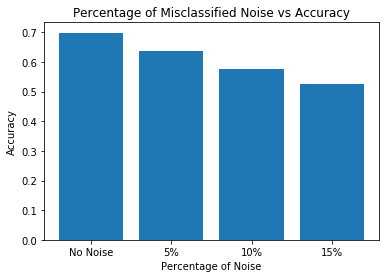

In [1039]:
y = [glass_mean_accuracy]+accuracies_under_misclassified_noise
plt.bar(["No Noise","5%","10%","15%"], y)
plt.title("Percentage of Misclassified Noise vs Accuracy")
plt.xlabel("Percentage of Noise")
plt.ylabel("Accuracy")
plt.show();

In [1067]:
def generate_contradictory_noise(data, val):    
    d=data
    label_column = data.iloc[:,9]
    unique_classes = np.unique(label_column)
    for _ in range(int(val*len(data))):
        random_index_for_data = np.random.randint(low=0, high=len(data))
        random_index_for_unique_labels = np.random.randint(low=0, high=len(unique_classes))
        new_row=data.iloc[random_index_for_data]
        new_row[9]=unique_classes[random_index_for_unique_labels]
        d=d.append(new_row)
    return d

In [1074]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data')
df.columns = [i for i in range(len(df.columns))]
# np.random.seed(1) 
np.random.seed(seed=None)

noises = [0.05,0.10,0.15]
accuracies_under_contradictory_noise = []
for noise in noises:

    my_accuracies = []
    for i in range(10):
        decision_tree = DecisionTree()
        train_df, test_df = train_test_k_fold_split(df, i)
        train_df = generate_contradictory_noise(train_df,noise)
        train_data, validation_data=split_training_and_validation(train_df, 0.2)
        decision_tree.build_tree(train_data)
        decision_tree.prune_tree(validation_data)
        decision_tree.get_rules()

        correct = 0
        for j in range(len(test_df)):
            example = test_df.iloc[j]
            if decision_tree.predict_class(example) is not None and decision_tree.predict_class(example)==example[9]: correct+=1

        my_accuracies.append(correct/len(test_df))
    print("For Noise ",noise,"Mean :", np.mean(my_accuracies)," Var :",np.var(my_accuracies))
    accuracies_under_contradictory_noise.append(np.mean(my_accuracies))

For Noise  0.05 Mean : 0.9163596491228072  Var : 0.0015883945060018462
For Noise  0.1 Mean : 0.9039473684210526  Var : 0.0015347943598030167
For Noise  0.15 Mean : 0.8944627192982455  Var : 0.002147550808902739


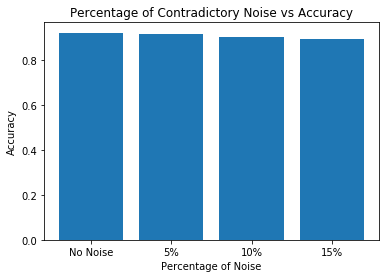

In [1077]:
y = [ttt_mean_accuracy]+accuracies_under_contradictory_noise
plt.bar(["No Noise","5%","10%","15%"], y)
plt.title("Percentage of Contradictory Noise vs Accuracy")
plt.xlabel("Percentage of Noise")
plt.ylabel("Accuracy")
plt.show();